In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from time import time

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [11]:
import h5py
import pandas as pd
import numpy as np

# Function to load embeddings from HDF5 file
def load_embeddings(file_path):
    embeddings = {}
    with h5py.File(file_path, 'r') as f:
        for key in f.keys():
            embeddings[key] = np.array(f[key])
    return embeddings

# Load embeddings
try:
    embeddings = load_embeddings('/Users/utkarsh/MMLI/equicat/develop_op/final_embeddings/embeddings.h5')
    print(f"Loaded embeddings for {len(embeddings)} entities")
    print("Sample keys from embeddings:", list(embeddings.keys()))
except FileNotFoundError:
    print("Error: 'embeddings.h5' file not found. Please ensure it's in the correct directory.")
    embeddings = {}
except Exception as e:
    print(f"Error loading embeddings: {str(e)}")
    embeddings = {}

# Load Y data
try:
    Y_df = pd.read_csv('/Users/utkarsh/MMLI/equicat/science/Y_DATA.csv', dtype={
        'catalyst_id': str,
        'imine_id': str,
        'thiol_id': str,
        'product_id': str
    })
    print(f"Loaded Y data with {len(Y_df)} rows")
    print("Sample rows from Y_df:")
    print(Y_df.head())
except FileNotFoundError:
    print("Error: 'Y_DATA.csv' file not found. Please ensure it's in the correct directory.")
    Y_df = pd.DataFrame()

# Check for missing IDs
missing_ids = set()
for _, row in Y_df.iterrows():
    for id_type in ['catalyst_id', 'imine_id', 'thiol_id', 'product_id']:
        if row[id_type] not in embeddings:
            missing_ids.add(row[id_type])

print(f"Number of missing IDs: {len(missing_ids)}")
print("Sample of missing IDs:", list(missing_ids)[:10] if missing_ids else "None")

# Additional checks
if embeddings:
    # Check for consistency in embedding dimensions
    embedding_sizes = set(emb.shape for emb in embeddings.values())
    if len(embedding_sizes) > 1:
        print("Warning: Inconsistent embedding sizes detected.")
        print("Unique embedding sizes:", embedding_sizes)
    else:
        print(f"All embeddings have consistent size: {next(iter(embedding_sizes))}")

    # Check for any potential data issues
    nan_keys = [key for key, emb in embeddings.items() if np.isnan(emb).any()]
    inf_keys = [key for key, emb in embeddings.items() if np.isinf(emb).any()]
    
    if nan_keys:
        print(f"Warning: NaN values found in embeddings for keys: {nan_keys[:10]}")
    if inf_keys:
        print(f"Warning: Inf values found in embeddings for keys: {inf_keys[:10]}")

# Print summary
print("\nSummary:")
print(f"Total embeddings loaded: {len(embeddings)}")
print(f"Total rows in Y_df: {len(Y_df)}")
print(f"Total missing IDs: {len(missing_ids)}")

Loaded embeddings for 507 entities
Sample keys from embeddings: ['100_vi', '102_i', '102_vi', '103_vi', '104_vi', '105_i', '105_vi', '106_i', '106_vi', '107_i', '108_i', '108_vi', '109_i', '109_vi', '10_vi', '110_i', '110_vi', '111_vi', '112_i', '112_vi', '114_i', '114_vi', '115_i', '115_vi', '116_i', '117_i', '117_vi', '118_vi', '119_i', '119_vi', '11_i', '11_vi', '120_i', '121_i', '122_vi', '123_i', '123_vi', '124_vi', '125_i', '125_vi', '127_vi', '128_vi', '129_i', '129_vi', '12_i', '130_i', '130_vi', '132_i', '133_vi', '134_vi', '135_i', '136_vi', '137_i', '137_vi', '139_i', '139_vi', '13_vi', '140_i', '141_i', '142_i', '142_vi', '143_i', '143_vi', '144_i', '146_i', '147_i', '148_i', '14_i', '150_i', '150_vi', '152_vi', '153_i', '153_vi', '154_i', '155_i', '155_vi', '156_i', '157_i', '157_vi', '158_i', '159_i', '159_vi', '15_i', '15_vi', '160_vi', '163_vi', '164_i', '164_vi', '165_i', '165_vi', '166_i', '166_vi', '167_i', '167_vi', '168_i', '168_vi', '169_i', '16_i', '16_vi', '170_

In [4]:
# Create X data using embeddings for catalyst, imine, thiol, and product
X_data = []
Y_data = []

for _, row in Y_df.iterrows():
    catalyst_id = row['catalyst_id']
    imine_id = row['imine_id']
    thiol_id = row['thiol_id']
    product_id = row['product_id']
    
    if all(id in embeddings for id in [catalyst_id, imine_id, thiol_id, product_id]):
        combined_embedding = np.concatenate([
            embeddings[catalyst_id],
            embeddings[imine_id],
            embeddings[thiol_id],
            embeddings[product_id]
        ])
        X_data.append(combined_embedding)
        Y_data.append(row['selectivity_ddGact_kcal'])
    else:
        print(f"Missing embedding for reaction: {row['reaction_handle']} - Missing IDs: {[id for id in [catalyst_id, imine_id, thiol_id, product_id] if id not in embeddings]}")

X_df = pd.DataFrame(X_data)
Y_series = pd.Series(Y_data)

print(f"Created dataset with {len(X_df)} samples and {X_df.shape[1]} features")
print("Sample rows from X_df:")
print(X_df.head())

if len(X_df) == 0:
    print("Error: No matching data found. Please check if the IDs in Y_DATA.csv match the keys in the embeddings file.")
    exit()


Missing embedding for reaction: 181_i_1_A - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_1_B - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_1_C - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_1_D - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_1_E - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_A - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_B - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_C - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_D - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_E - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_A - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_B - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_C - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_D - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_E - Missing IDs: ['181

In [13]:
seed = 4815162342 // 2
np.random.seed(seed)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.4, random_state=seed)

f_select_model = RandomForestRegressor(n_estimators=1000, n_jobs=64, random_state=1234)

pipe_random = Pipeline(steps=[
    ('preprocess', VarianceThreshold(1e-3)),
    ('feature_selection', SelectFromModel(f_select_model, max_features=30)),
    ('model', XGBRegressor(n_estimators=500, learning_rate=0.01))
])

param_dict = {
    'model__learning_rate': np.logspace(-4, 0, 20),
    'model__subsample': np.linspace(0.5, 1.0, 10),
    'model__colsample_bytree': np.linspace(0.1, 1.0, 10),
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
    'model__min_child_weight': np.linspace(1, 10, 10),
    'model__gamma': np.linspace(0, 1, 10),
    'model__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

search = RandomizedSearchCV(pipe_random, cv=5, param_distributions=param_dict,
                            n_iter=100, n_jobs=64, verbose=3, refit='neg_mean_absolute_error',
                            scoring=['neg_mean_absolute_error', 'r2'])

t0 = time()
print("Fitting started...")
search = search.fit(X_train, Y_train)
print(f"Fitting took {time() - t0:0.3f}s.")

best_model = search.best_estimator_

print("Best parameters found:")
for param, value in search.best_params_.items():
    print(f"{param}: {value}")

Fitting started...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END model__colsample_bytree=0.30000000000000004, model__gamma=0.7777777777777777, model__learning_rate=0.3792690190732246, model__max_depth=5, model__min_child_weight=10.0, model__n_estimators=300, model__subsample=0.9444444444444444; neg_mean_absolute_error: (test=-0.198) r2: (test=0.860) total time=  16.9s
[CV 4/5] END model__colsample_bytree=0.30000000000000004, model__gamma=0.7777777777777777, model__learning_rate=0.3792690190732246, model__max_depth=5, model__min_child_weight=10.0, model__n_estimators=300, model__subsample=0.9444444444444444; neg_mean_absolute_error: (test=-0.202) r2: (test=0.838) total time= 1.1min
[CV 2/5] END model__colsample_bytree=0.30000000000000004, model__gamma=0.7777777777777777, model__learning_rate=0.3792690190732246, model__max_depth=5, model__min_child_weight=10.0, model__n_estimators=300, model__subsample=0.9444444444444444; neg_mean_absolute_error: (test=-0.17

In [16]:
Y_pred_train = best_model.predict(X_train)
Y_pred_test = best_model.predict(X_test)

train_r2 = r2_score(Y_train, Y_pred_train)
train_mae = mean_absolute_error(Y_train, Y_pred_train)
test_r2 = r2_score(Y_test, Y_pred_test)
test_mae = mean_absolute_error(Y_test, Y_pred_test)

print(f"Train R^2: {train_r2:.5f}, train MAE: {train_mae:.5f}")
print(f"Test R^2: {test_r2:.5f}, test MAE: {test_mae:.5f}")

Train R^2: 0.92936, train MAE: 0.12899
Test R^2: 0.90314, test MAE: 0.15338


In [17]:
def predict_ddg(catalyst_id, imine_id, thiol_id, product_id):
    if all(id in embeddings for id in [catalyst_id, imine_id, thiol_id, product_id]):
        combined_embedding = np.concatenate([
            embeddings[catalyst_id],
            embeddings[imine_id],
            embeddings[thiol_id],
            embeddings[product_id]
        ])
        return best_model.predict([combined_embedding])[0]
    else:
        return "One or more components not found in embeddings"

# Example usage
example_row = Y_df.iloc[3]
print(f"Prediction for reaction {example_row['reaction_handle']}: "
      f"{predict_ddg(example_row['catalyst_id'], example_row['imine_id'], example_row['thiol_id'], example_row['product_id']):.4f}")

Prediction for reaction 1_i_1_D: 1.1572


Plotting results...
EQUICAT Prediction
Train R^2: 0.92936, train MAE: 0.12899
Test R^2: 0.90314, test MAE: 0.15338


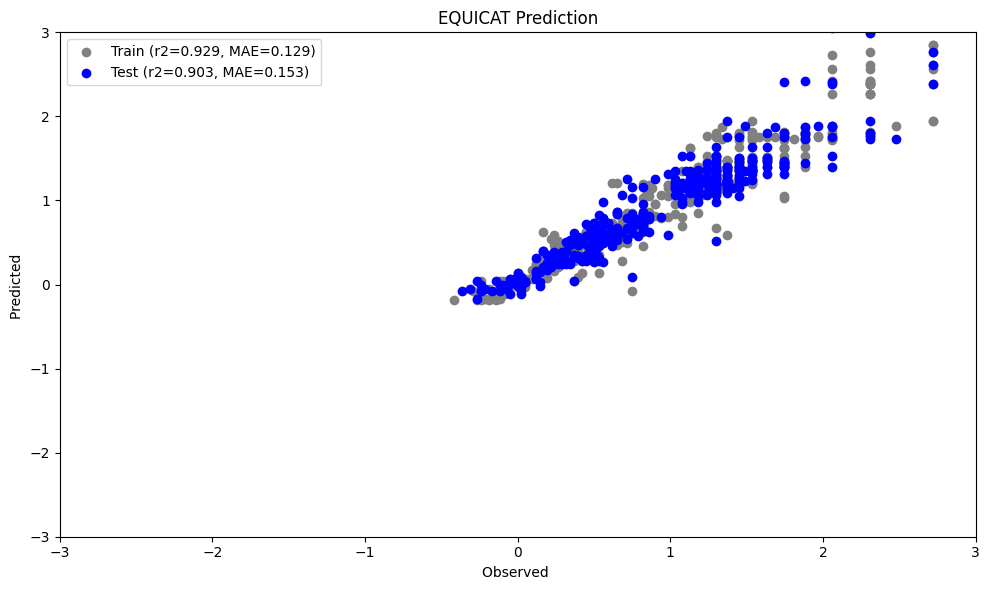

In [21]:
import matplotlib.pyplot as plt

def plot_and_print(estimator, X_train, Y_train, X_test, Y_test, title, verbose=1, file_dpi=800):
    predicted_train = estimator.predict(X_train)
    r2_train = r2_score(Y_train, predicted_train)
    mae_train = mean_absolute_error(Y_train, predicted_train)

    predicted_test = estimator.predict(X_test)
    r2_test = r2_score(Y_test, predicted_test)
    mae_test = mean_absolute_error(Y_test, predicted_test)

    if verbose:
        print(title)
        print(f"Train R^2: {r2_train:0.5f}, train MAE: {mae_train:0.5f}")
        print(f"Test R^2: {r2_test:0.5f}, test MAE: {mae_test:0.5f}")
    
    fig, ax = plt.subplots(figsize=(10, 6))

    train_plot = ax.scatter(
        Y_train,
        predicted_train,
        color="gray",
        label=f"Train (r2={r2_train:0.3f}, MAE={mae_train:0.3f})"
    )

    test_plot = ax.scatter(
        Y_test,
        predicted_test,
        color="blue",
        label=f"Test (r2={r2_test:0.3f}, MAE={mae_test:0.3f})"
    )

    ax.set_title(title)
    ax.set_xlabel("Observed ")
    ax.set_ylabel("Predicted ")
    ax.set_ylim(-3, 3)
    ax.set_xlim(-3, 3)
        
    plt.legend()
    plt.tight_layout()
    plt.savefig(title + ".png", dpi=file_dpi)
    plt.show()
    plt.close()

# Plot and print results
print("Plotting results...")
plot_and_print(best_model, X_train, Y_train, X_test, Y_test, "EQUICAT Prediction")